In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

# Step 1: Load financial data
symbol_crypto = 'SPY'
start_date = "1970-01-01"
end_date = "2025-12-31"
df = yf.download(symbol_crypto, start=start_date, end=end_date)

df['log_close'] = np.log(df['Close'])

def get_realized_vol(dataset, time):
    dataset['returns'] = np.log(dataset["Close"] / dataset["Close"].shift(1))
    dataset.fillna(0, inplace=True)
    # Rolling window volatility
    volatility = dataset['returns'].rolling(window=time).std(ddof=0)
    return volatility

df['RV'] = get_realized_vol(df, 21)

df['RV']

[*********************100%***********************]  1 of 1 completed


,RV
Date,
1993-01-29,NaN
1993-02-01,NaN
1993-02-02,NaN
1993-02-03,NaN
1993-02-04,NaN
...,...
2024-10-10,0.006129
2024-10-11,0.006026
2024-10-14,0.006139


In [ ]:
# Step 3: Preprocess data
dataset = df['RV'].dropna().values.reshape(-1, 1)

import math

training_data_len = math.ceil(len(dataset)*.8)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.09586729],
       [0.10661656],
       [0.10517594],
       ...,
       [0.0719442 ],
       [0.07797881],
       [0.07842815]])

In [ ]:
train_data = scaled_data[0:training_data_len,:]


x_train=[]
y_train=[]

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.09586729, 0.10661656, 0.10517594, 0.10719114, 0.10202192,
       0.12519485, 0.12590588, 0.12596756, 0.12368879, 0.12932579,
       0.12930923, 0.12616877, 0.09164618, 0.09238869, 0.09581098,
       0.09842973, 0.09816882, 0.0980385 , 0.09169361, 0.09394099,
       0.09461933, 0.09404317, 0.08209423, 0.0818336 , 0.10500937,
       0.10643937, 0.07462858, 0.07607931, 0.0752721 , 0.08961901,
       0.08391898, 0.08236445, 0.08236445, 0.08007031, 0.07820516,
       0.07732736, 0.07555588, 0.08452356, 0.08507405, 0.08379004,
       0.09190621, 0.09020545, 0.09108306, 0.09149608, 0.0943195 ,
       0.06711957, 0.06601312, 0.06636098, 0.06588393, 0.06602249,
       0.05179678, 0.0513651 , 0.06163162, 0.0615626 , 0.06302028,
       0.06212502, 0.0886691 , 0.08884583, 0.08354183, 0.08233943])]
[0.0765946120103206]



In [ ]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data into 3 dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(6313, 60, 1)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping



# Step 2: Redesign the model architecture
def create_optimized_model():
    model = Sequential()

    # Input Layer + Batch Normalization
    model.add(Dense(256, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))


    # Hidden Layer 1
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Hidden Layer 2
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))


    # Hidden Layer 3
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())


    # Output Layer for regression (single neuron for continuous output)
    model.add(Dense(1))

    # Compile model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

# Step 3: Create the model
model = create_optimized_model()




/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Step 4: Add callbacks
# - ReduceLROnPlateau: Reduces the learning rate when a plateau in loss is detected.
# - EarlyStopping: Stops training if the validation loss doesn't improve after a few epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 5: Train the model
history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

# Step 6: Evaluate the model
results = model.evaluate(x_train, y_train)
print(f"Test Loss: {results[0]}, Test MAE: {results[1]}")

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 1.2168 - mae: 0.8458 - val_loss: 0.0047 - val_mae: 0.0608 - learning_rate: 0.0010
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.4285 - mae: 0.4906 - val_loss: 0.0061 - val_mae: 0.0576 - learning_rate: 0.0010
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.2091 - mae: 0.3519 - val_loss: 0.0070 - val_mae: 0.0686 - learning_rate: 0.0010
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1631 - mae: 0.3075 - val_loss: 0.0119 - val_mae: 0.1012 - learning_rate: 0.0010
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1123 - mae: 0.2538 - val_loss: 0.0034 - val_mae: 0.0440 - learning_rate: 0.0010
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0846 - mae: 0.2214 - val_loss: 0.0069 - val_mae: 0.0674 - learning_rate: 0.0010
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0610 - mae: 0.1870 - val_loss: 0.0075 - val_mae: 0.0747 - learning_rate: 0.0010
Epoch 

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          15,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 629,893 (2.40 MB)

 Trainable params: 209,217 (817.25 KB)

 Non-trainable params: 2,240 (8.75 KB)

 Optimizer params: 418,436 (1.60 MB)

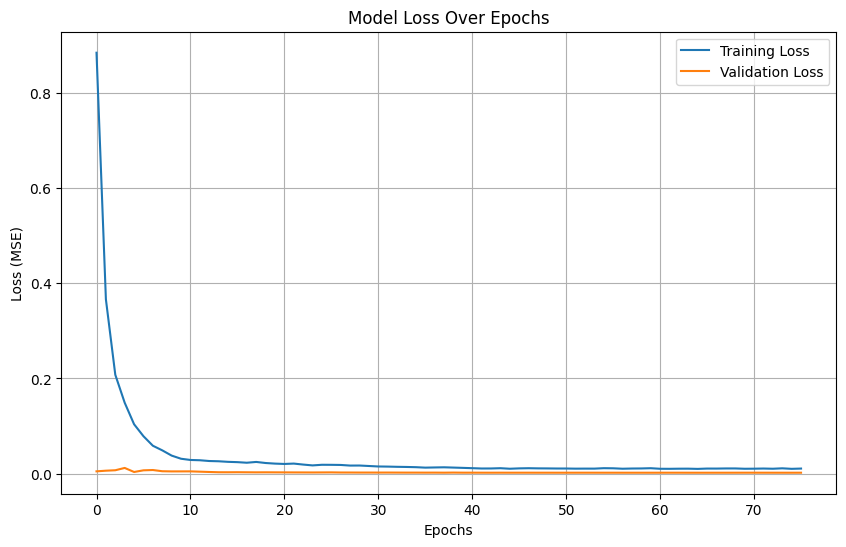

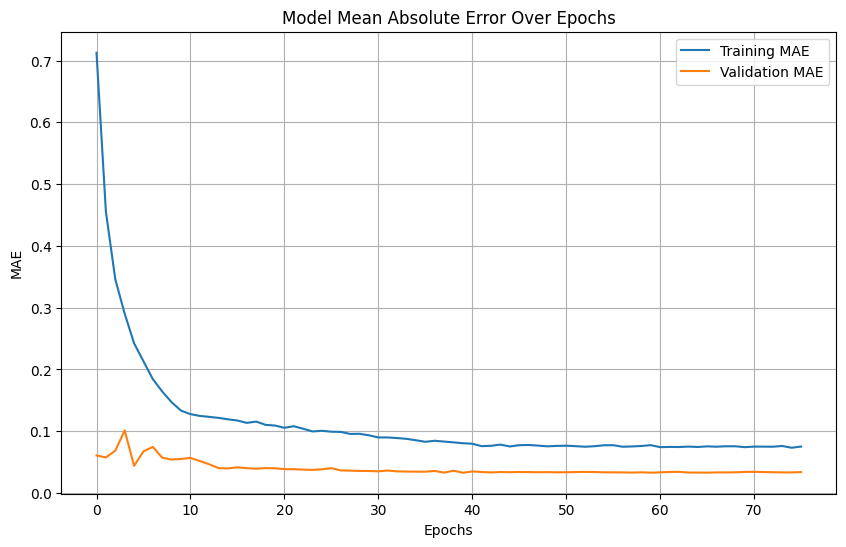

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss over epochs
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Mean Absolute Error over epochs
def plot_mae(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model Mean Absolute Error Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plotting functions
plot_loss(history)
plot_mae(history)


In [ ]:
#Create the test data set
#Create a new array containing scaled values

test_data=scaled_data[training_data_len-60: , : ]
#Create the data sets x_test and y_test

x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])



x_test=np.array(x_test)
# Reshape the data to 3D
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [ ]:

predictions=model.predict(x_test)
predictions = predictions.reshape(predictions.shape[0], -1)  # Reshape to (1591, 60)
predictions = scaler.inverse_transform(predictions)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

actual_value = dataset[training_data_len: , : ]


def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))


# Step 3: Calculate metrics for the test set
mae_test = mean_absolute_error(actual_value, predictions)
rmse_test = np.sqrt(mean_squared_error(actual_value, predictions))
mape_test = mean_absolute_percentage_error(actual_value, predictions)
r2 = r2_score(actual_value, predictions)

rmspe_value = rmspe(actual_value, predictions)

# Print the RMSPE result
print(f"RMSPE: {rmspe_value}")

# Print the metrics
print(f"Test MAE: {mae_test}")
print(f"Test RMSE: {rmse_test}")
print(f"Test MAPE: {mape_test}")
print(f"Test r2: {r2}")


RMSPE: 0.32257474082700793
Test MAE: 0.0022896110981919246
Test RMSE: 0.003169230400725733
Test MAPE: 0.2477019899581063
Test r2: 0.7847851448936988


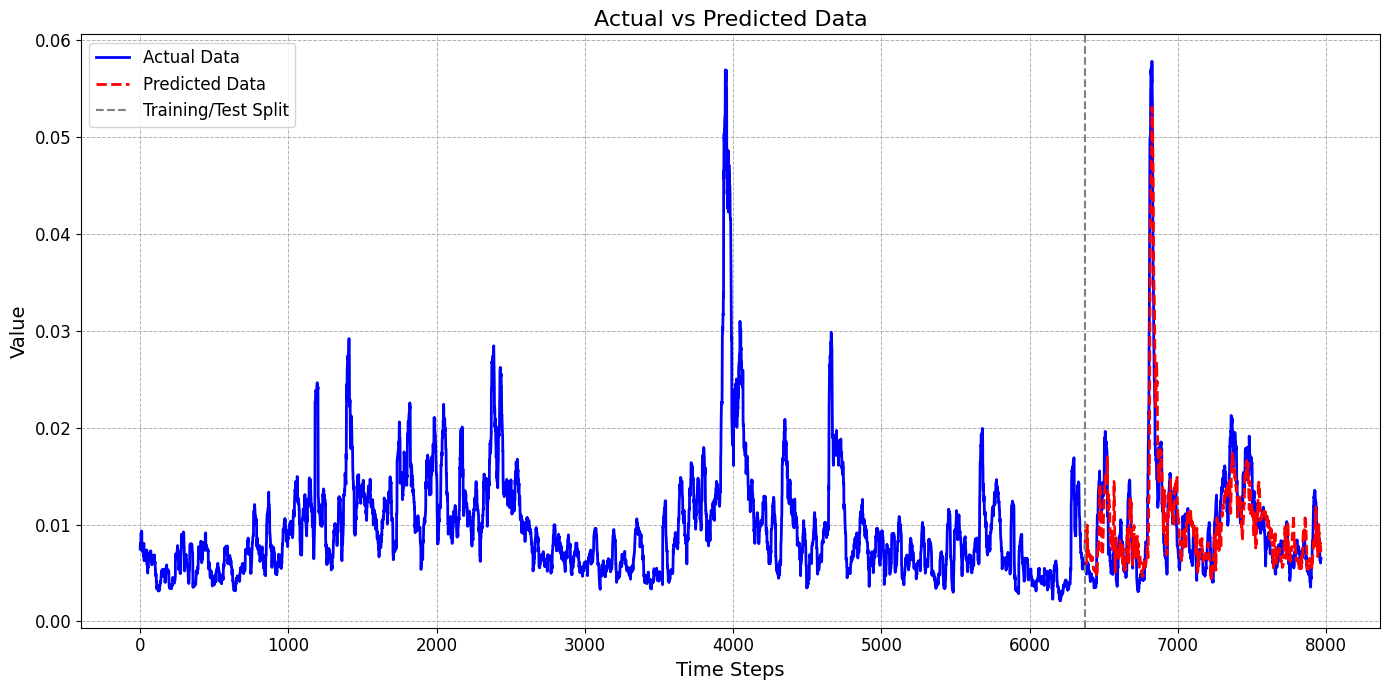

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test contains the actual data in the original scale
# Assuming predictions contains the predicted data in the original scale
# Assuming dataset contains all actual values including training and testing

# Create a figure with specified size
plt.figure(figsize=(14, 7))

# Plot actual data
plt.plot(np.arange(len(dataset)), dataset, label='Actual Data', color='blue', linewidth=2)

# Plot predicted data
plt.plot(np.arange(training_data_len, len(dataset)), predictions, color='red', linewidth=2, linestyle='--', label='Predicted Data')

# Highlighting the training and testing data separation
plt.axvline(x=training_data_len, color='gray', linestyle='--', label='Training/Test Split')

# Add labels and title
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Actual vs Predicted Data', fontsize=16)

# Show legend with a specific location
plt.legend(loc='upper left', fontsize=12)

# Adding grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Set x and y ticks for better visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


# Get statisitc from MODEL

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 0.012248625978827477, Test MAE: 0.08871136605739594
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Iteration 0 complete
Iteration 0 complete: MAE=0.004909578956844279, RMSE=0.006779096803998431, MAPE=0.649186120458539, R2=0.015290132884784091



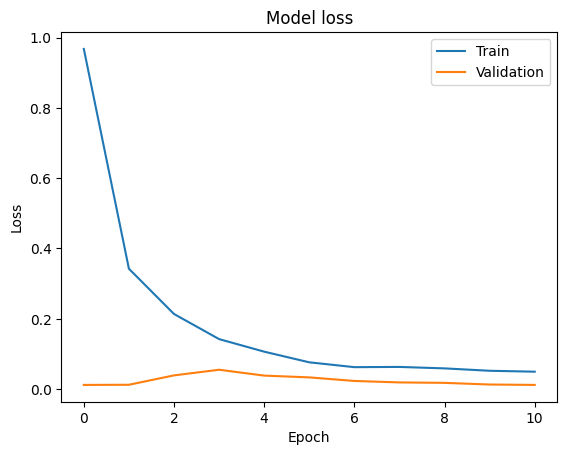

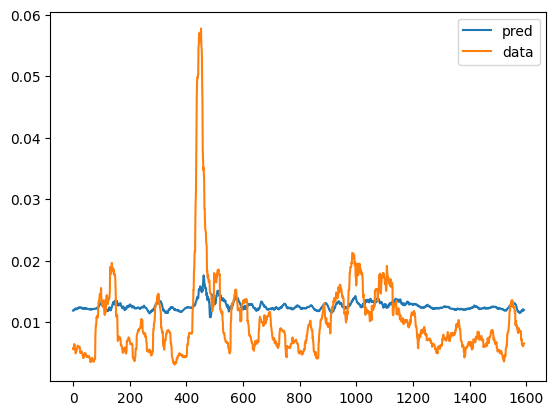

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 0.0026072703767567873, Test MAE: 0.03661159798502922
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Iteration 1 complete
Iteration 1 complete: MAE=0.002427955749414513, RMSE=0.0036627581532218813, MAPE=0.2664358970040531, R2=0.712537561003256



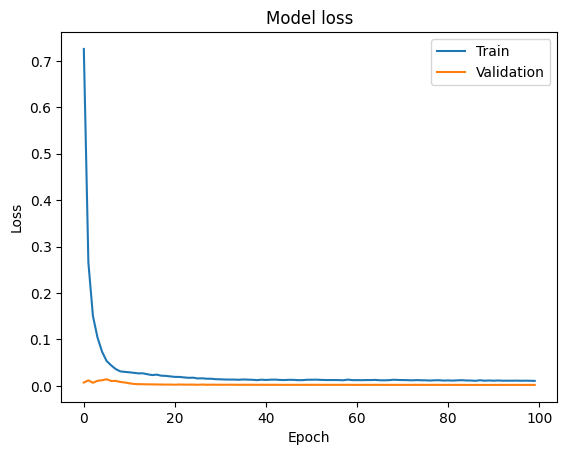

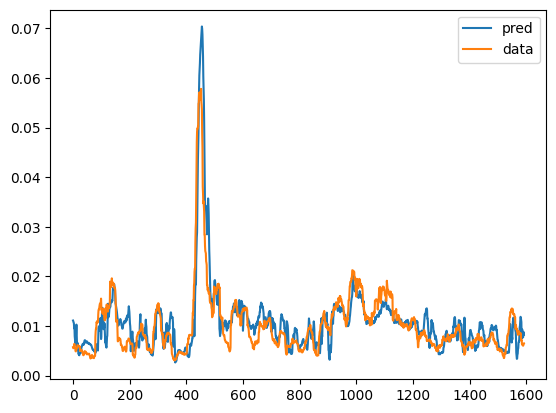

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 0.014118838123977184, Test MAE: 0.07698152214288712
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Iteration 2 complete
Iteration 2 complete: MAE=0.004472883078445117, RMSE=0.007519649671273384, MAPE=0.3572231532188278, R2=-0.2116015896685013



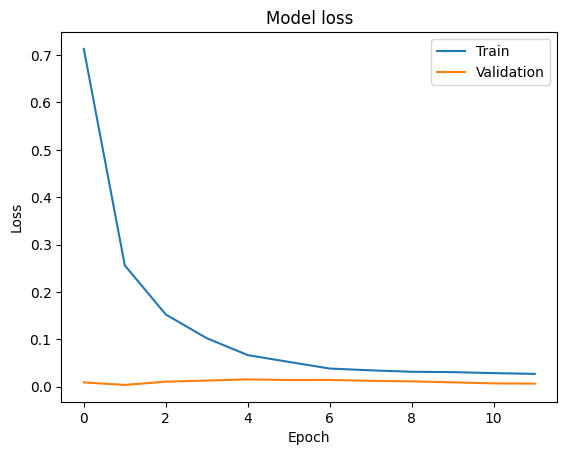

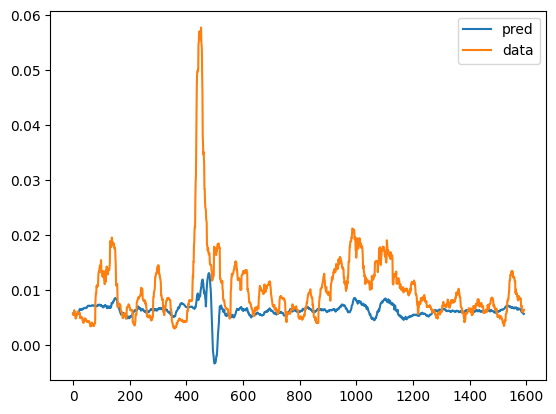

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 0.004911674652248621, Test MAE: 0.05174044519662857
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Iteration 3 complete
Iteration 3 complete: MAE=0.0033601678841676795, RMSE=0.004565397856342187, MAPE=0.38372693031988236, R2=0.5533967494836556



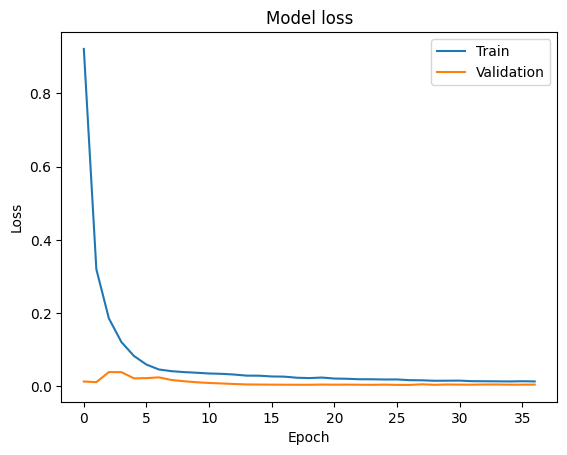

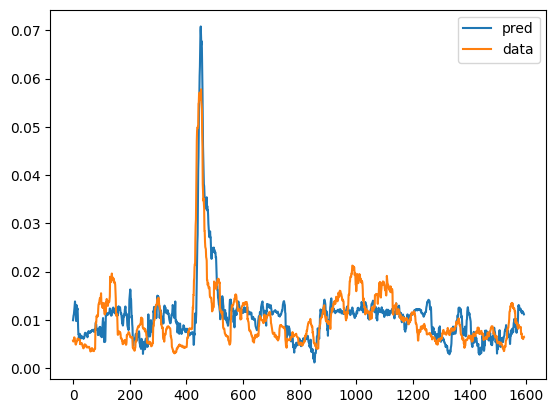

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 0.012661190703511238, Test MAE: 0.06652447581291199
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Iteration 4 complete
Iteration 4 complete: MAE=0.004058990822472195, RMSE=0.007235654485121114, MAPE=0.3083137679519404, R2=-0.12181245970466725



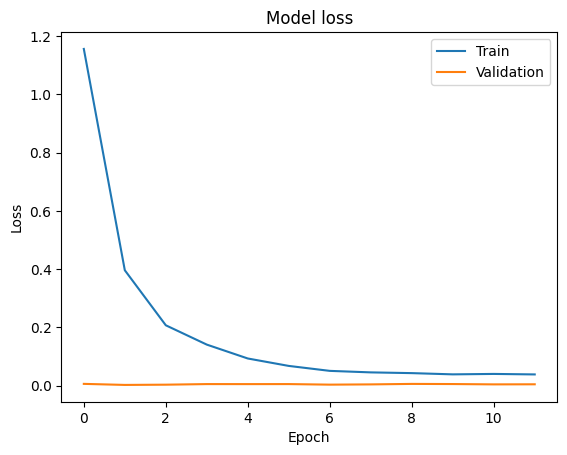

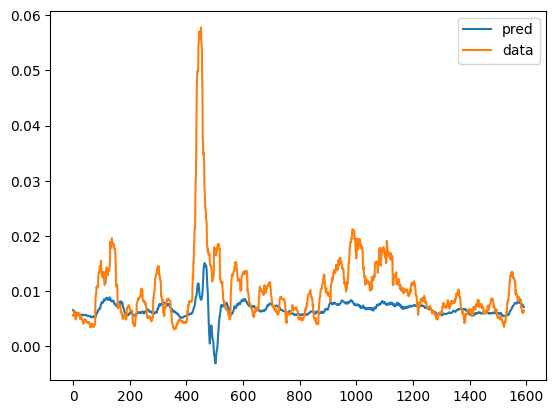

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 0.01105719618499279, Test MAE: 0.0710931196808815
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Iteration 5 complete
Iteration 5 complete: MAE=0.0041489522761143155, RMSE=0.00698617917072974, MAPE=0.4496803510285612, R2=-0.04578897163327933



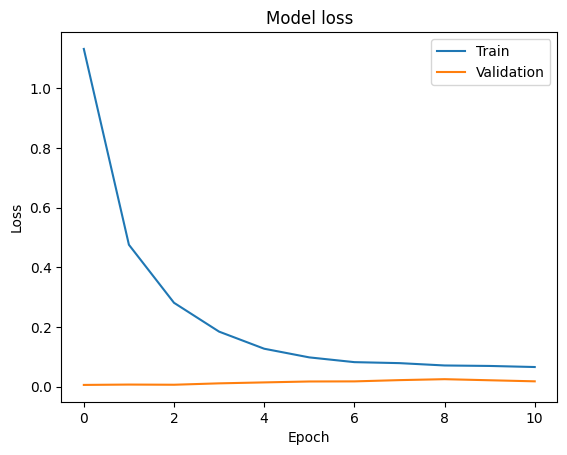

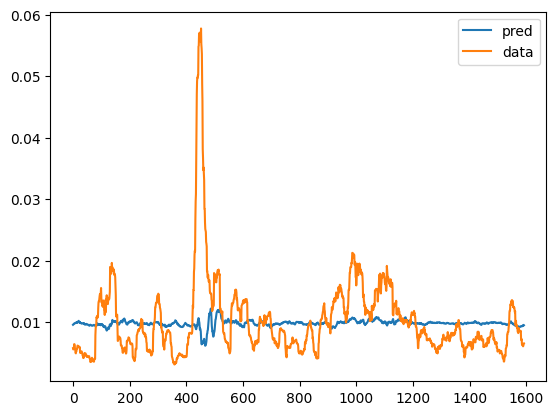

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 0.006306556053459644, Test MAE: 0.0512942373752594
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Iteration 6 complete
Iteration 6 complete: MAE=0.003270100276416212, RMSE=0.0051688437685592885, MAPE=0.3206092157506137, R2=0.4275317175264758



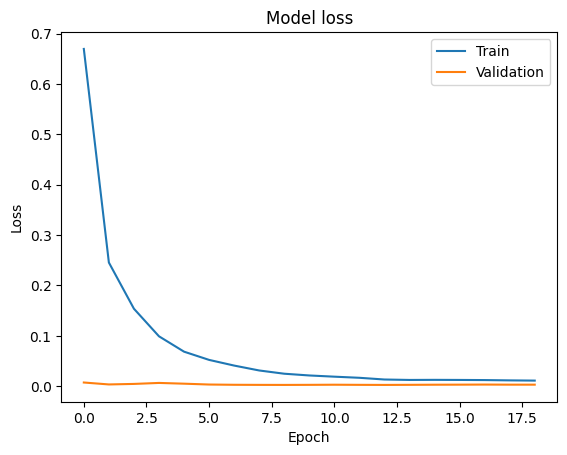

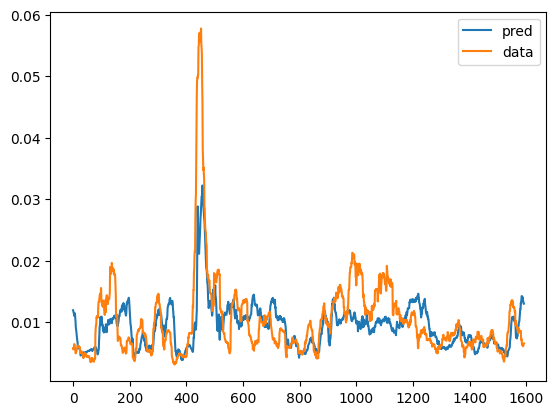

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 0.010374700650572777, Test MAE: 0.06299189478158951
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Iteration 7 complete
Iteration 7 complete: MAE=0.003957178646648688, RMSE=0.006765403778754774, MAPE=0.3306840932040819, R2=0.019264125205613603



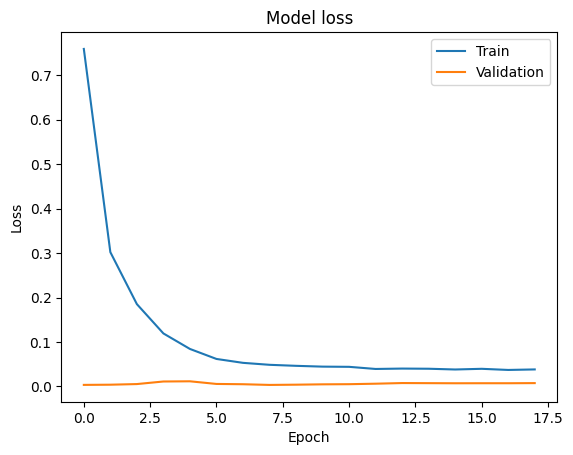

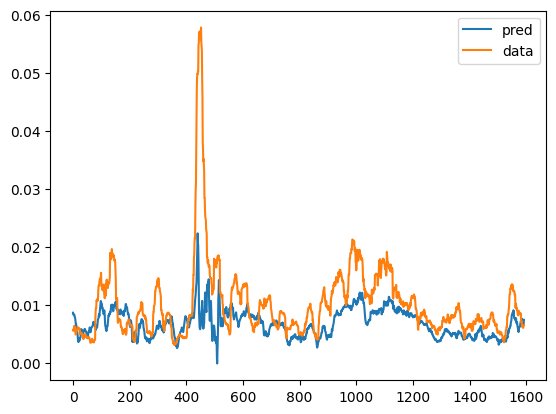

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 0.010363458655774593, Test MAE: 0.058175187557935715
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Iteration 8 complete
Iteration 8 complete: MAE=0.003677196022484321, RMSE=0.006845368172794144, MAPE=0.32161671762598754, R2=-0.004056706052762982



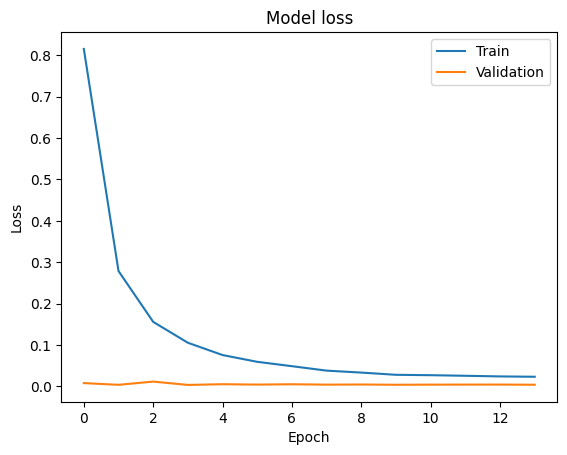

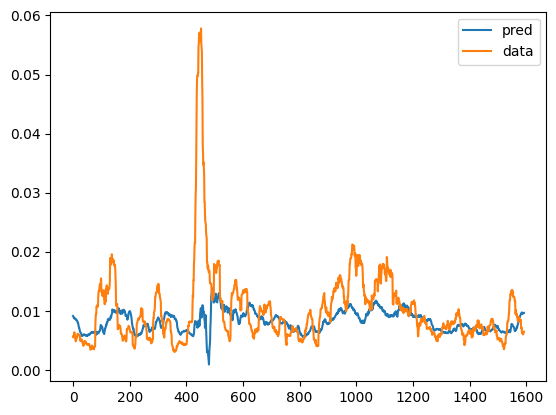

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

actual_value = dataset[training_data_len: , : ]

mae_ = []
rmse_ = []
mape_ = []
r2_ = []



for i in np.arange(100):

      # Reinitialize the model to get fresh, untrained weights
    model = create_optimized_model()

    # # Save the initial weights before the loop
    # initial_weights = model.get_weights()


    # # Reset the model to initial weights at the start of each iteration
    # model.set_weights(initial_weights)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Step 5: Train the model
    history = model.fit(
        x_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=128,
        callbacks=[reduce_lr, early_stopping],
        verbose=0  # Suppress the output
    )

    # Step 6: Evaluate the model
    results = model.evaluate(x_train, y_train, verbose=0)  # Set verbose to 0 for silent mode
    print(f"Test Loss: {results[0]}, Test MAE: {results[1]}")

    # Step 7: Make predictions
    predictions = model.predict(x_test)
    predictions = predictions.reshape(predictions.shape[0], -1)  # Reshape to match scaler's expected input
    predictions = scaler.inverse_transform(predictions)  # Inverse transform the predictions

    # Step 8: Calculate metrics
    mae_test = mean_absolute_error(actual_value, predictions)
    mae_.append(mae_test)

    rmse_test = np.sqrt(mean_squared_error(actual_value, predictions))
    rmse_.append(rmse_test)

    mape_test = mean_absolute_percentage_error(actual_value, predictions)
    mape_.append(mape_test)

    r2 = r2_score(actual_value, predictions)
    r2_.append(r2)
    print(f"Iteration {i} complete")

    print(f"Iteration {i} complete: MAE={mae_test}, RMSE={rmse_test}, MAPE={mape_test}, R2={r2}")

    print(f"")

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    plt.plot(predictions, label = 'pred')
    plt.plot(dataset[training_data_len: , : ], label = 'data')
    plt.legend()

    plt.show()

In [ ]:
import pandas as pd
import numpy as np


# Create a DataFrame to store the metrics
metrics_data = {
    'MAE': mae_,
    'RMSE': rmse_,
    'MAPE': mape_,
    'R2': r2_
}

df_metrics = pd.DataFrame(metrics_data)

# Save the DataFrame to an Excel file
file_path = "lstm_metrics.xlsx"
df_metrics.to_excel(file_path, index=False)

print(f"Metrics have been saved to {file_path}")


In [ ]:

# Calculate summary statistics
summary = df_metrics.describe()

print(summary)

In [ ]:
# Plot histograms for each metric
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(mae_, bins=10, color='blue', edgecolor='black')
plt.title('MAE Distribution')
plt.xlabel('MAE')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(rmse_, bins=10, color='green', edgecolor='black')
plt.title('RMSE Distribution')
plt.xlabel('RMSE')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(mape_, bins=10, color='red', edgecolor='black')
plt.title('MAPE Distribution')
plt.xlabel('MAPE (%)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(r2_, bins=10, color='purple', edgecolor='black')
plt.title('R² Distribution')
plt.xlabel('R²')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
